## New York Times Covid-19 Data (US)

In [9]:
# no need to clone the repo since we are loading the CSVs directly from a URL
# !rm -rf data/covid-19-data && mkdir data/covid-19-data
# !git clone https://github.com/nytimes/covid-19-data.git data/covid-19-data/

## Zip Code data 

In [10]:
!wget https://data.healthcare.gov/api/views/52wv-g36k/rows.csv -O data/zip_codes.csv

--2020-04-14 17:23:31--  https://data.healthcare.gov/api/views/52wv-g36k/rows.csv
Resolving data.healthcare.gov (data.healthcare.gov)...23.4.58.194, 2600:1404:1800:69b::1fc4, 2600:1404:1800:688::1fc4
Connecting to data.healthcare.gov (data.healthcare.gov)|23.4.58.194|:443...connected.
HTTP request sent, awaiting response...200 OK
Length: unspecified [text/csv]
Saving to: ‘data/zip_codes.csv’

data/zip_codes.csv      [    <=>             ]   2.68M  3.98MB/s    in 0.7s    

2020-04-14 17:23:33 (3.98 MB/s) - ‘data/zip_codes.csv’ saved [2807117]



## County Adjacancy Data 

In [11]:
!wget https://www2.census.gov/geo/docs/reference/county_adjacency.txt -O data/county_adjacency.txt

--2020-04-14 17:23:33--  https://www2.census.gov/geo/docs/reference/county_adjacency.txt
Resolving www2.census.gov (www2.census.gov)...172.226.182.13, 2600:1404:27:28f::208c, 2600:1404:27:28d::208c
Connecting to www2.census.gov (www2.census.gov)|172.226.182.13|:443... connected.
HTTP request sent, awaiting response...200 OK
Length: unspecified [text/plain]
Saving to: ‘data/county_adjacency.txt’

data/county_adjacen     [ <=>                ] 709.69K  --.-KB/s    in 0.1s    

2020-04-14 17:23:34 (4.89 MB/s) - ‘data/county_adjacency.txt’ saved [726724]



In [12]:
_states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [13]:
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
zipcodes = pd.read_csv('data/zip_codes.csv')
zipcodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42522 entries, 0 to 42521
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zip                   42522 non-null  int64  
 1   primary_city          42522 non-null  object 
 2   state                 42522 non-null  object 
 3   latitude              42522 non-null  float64
 4   longitude             42522 non-null  float64
 5   county                41672 non-null  object 
 6   type                  42522 non-null  object 
 7   world_region          333 non-null    object 
 8   country               42522 non-null  object 
 9   decommissioned        42522 non-null  int64  
 10  estimated_population  42522 non-null  int64  
 11  notes                 1331 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 3.9+ MB


### County Adjacency Parser

Parse through txt file and generate formatted json.
Will be used in web app, so json output is ideal

In [15]:
def adjacency_parser(file_name):
    with open(file_name, errors='ignore') as f:
        current_county = None
        ret = {}
        for line in f:
            cleaned = line.replace('\"','').strip().split('\t')
            if line.startswith('\t\t') and len(cleaned) == 2 and current_county is not None:
                # key = current_county[0].split(',')[0]
                key = current_county[1]
                ret[key] = ret.get(key, []) + [cleaned[1]]
            else:
                current_county = cleaned            
        return ret

adj_zip_codes = adjacency_parser('data/county_adjacency.txt')

In [16]:
# or just use the csv 
adj = pd.read_csv('data/county_adjacency2010.csv')

#mappers
state = lambda y: _states[y['countyname'].split(',')[1].strip()]
county = lambda y: y['countyname'].split(',')[0].replace(' County',  '')

neighbor_state = lambda y: _states[y['neighborname'].split(',')[1].strip()]
neighbor_county = lambda y: y['neighborname'].split(',')[0].replace(' County',  '')

#map values
a = adj.apply(state, axis=1)
b = adj.apply(county, axis=1)
c = adj.apply(neighbor_county, axis=1)
d = adj.apply(neighbor_state, axis=1)

#update dataframe
adj = adj.assign(state=a.values)
adj = adj.assign(county=b.values)
adj = adj.assign(neighborcounty=c.values)
adj = adj.assign(neighborstate=d.values)

adj_groups = adj.groupby(['state', 'county'])

In [17]:
zip_code = 75010
zipcodes[zipcodes['zip'] == zip_code]

,zip,primary_city,state,latitude,longitude,county,type,world_region,country,decommissioned,estimated_population,notes
32621,75010,Carrollton,TX,32.98,-96.89,Denton,STANDARD,NaN,US,0,17158,NaN


In [18]:
# files = ['us-counties','us-states']
# counties, states = [pd.read_csv('data/covid-19-data/{}.csv'.format(f)) for  f in files]

counties = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')

In [19]:
print('--------------------States--------------------')
states.info()
print('\n\n--------------------Counties--------------------')
counties.info()

--------------------States--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2329 non-null   object
 1   state   2329 non-null   object
 2   fips    2329 non-null   int64 
 3   cases   2329 non-null   int64 
 4   deaths  2329 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 91.1+ KB


--------------------Counties--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56541 entries, 0 to 56540
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    56541 non-null  object 
 1   county  56541 non-null  object 
 2   state   56541 non-null  object 
 3   fips    55795 non-null  float64
 4   cases   56541 non-null  int64  
 5   deaths  56541 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 2.6+ MB


In [20]:
county_groups = counties.groupby(['state','county'])

In [21]:
location = ('Texas', 'Travis')
travis_county = county_groups.get_group(location)
travis_county['days'] = range(0,travis_county.shape[0])

Text(0.5, 1.0, 'Travis County, Texas')

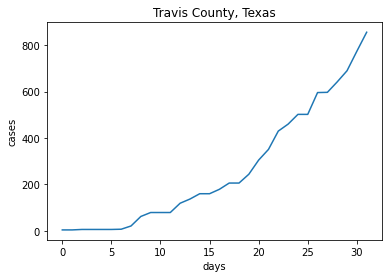

In [22]:
chart = sns.lineplot(x='days', y='cases', data=travis_county)
chart.set_title('{} County, {}'.format(location[1], location[0]))


In [23]:
def show_county_covid_growth(groups, locations, single_graph=False):
    labels = []
    for i,  location in enumerate(locations):
        title = 'Covid-19 Cases by County'
        labels.append(location)
        try:
            data = groups.get_group(location)
            data['days'] = range(0,data.shape[0])
            if not single_graph: 
                plt.figure(i)
                title = '{} County, {}'.format(location[1], location[0])
            else:
                plt.legend(labels=labels)
            chart = sns.lineplot(x='days', y='cases', data=data)
            chart.set_title(title)
        except KeyError:
            print('Could not find data for {}'.format(location))
        except:
            print('Failed')

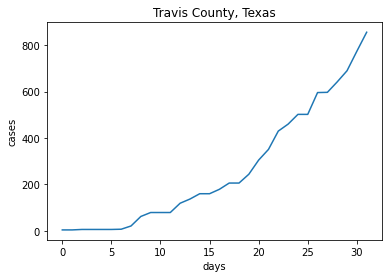

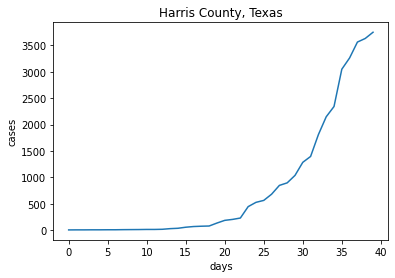

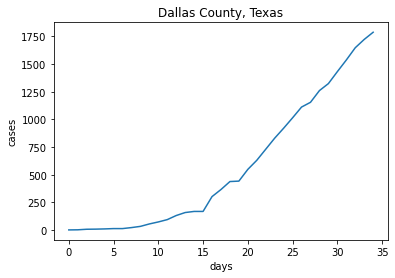

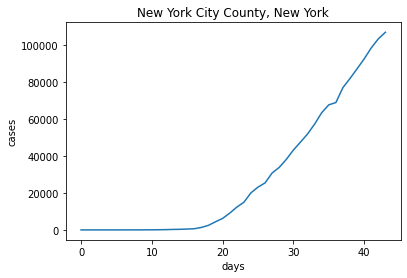

In [24]:
places = [
    ('Texas', 'Travis'),
    ('Texas', 'Harris'),
    ('Texas', 'Dallas'),
    ('New York', 'New York City')
]

show_county_covid_growth(county_groups, places, single_graph=False)


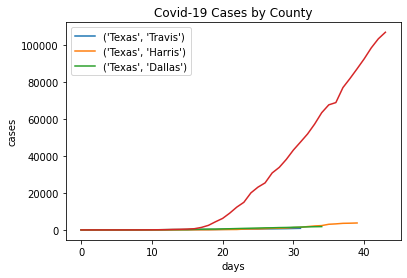

In [25]:
show_county_covid_growth(county_groups, places, single_graph=True)

In [26]:
latest_per_county = counties.loc[counties.groupby(['state','county'])['cases'].idxmax()]

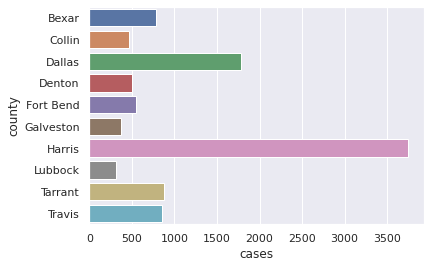

In [27]:
# counties per state with at least N cases
state = 'Texas'
min_cases = 300
data = latest_per_county[(latest_per_county['state'] == state) & (latest_per_county['cases'] > min_cases)]
sns.set(style="darkgrid")
sns.barplot(x="cases", y="county", data=data)

In [28]:
counties[counties['state'] == 'New York']

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,NaN,1,0
448,2020-03-02,New York City,New York,NaN,1,0
482,2020-03-03,New York City,New York,NaN,2,0
518,2020-03-04,New York City,New York,NaN,2,0
519,2020-03-04,Westchester,New York,36119.0,9,0
...,...,...,...,...,...,...
55467,2020-04-13,Washington,New York,36115.0,37,0
55468,2020-04-13,Wayne,New York,36117.0,42,0
55469,2020-04-13,Westchester,New York,36119.0,19785,610
55470,2020-04-13,Wyoming,New York,36121.0,31,3


In [29]:
def show_neighbor_county_cases(county_groups, adj_groups, location, single_graph=False):
    
    dta = adj_groups.get_group(location)
    h = dta.apply(lambda y: (y['neighborstate'], y['neighborcounty']), axis=1)
    show_county_covid_growth(county_groups, h.values, single_graph=single_graph)

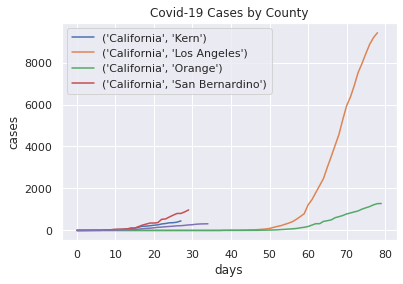

In [30]:
loc = ('California', 'Los Angeles')
show_neighbor_county_cases(county_groups, adj_groups, loc, single_graph=True)

In [31]:
# counties[(counties.county == 'Los Angeles') & (counties.cases > 10) ]


In [74]:
import plotly.figure_factory as ff

state = 'Texas'
condition = (latest_per_county.state == state) & (latest_per_county.fips.notnull())
state_data = latest_per_county[condition]
# values = df_sample_r['TOT_POP'].tolist()
fips = state_data['fips'].tolist()
cases = state_data['cases'].tolist()
colorscale = [
    'rgb(193, 193, 193)',
    'rgb(239,239,239)',
    'rgb(195, 196, 222)',
    'rgb(144,148,194)',
    'rgb(101,104,168)',
    'rgb(65, 53, 132)'
]

fig = ff.create_choropleth(
    fips=fips, values=cases, scope=[state],
    # binning_endpoints=[10, 100, 500, 1000, 2000], colorscale=colorscale,
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Cases by County', title='{} Coronavirus Cases'.format(state)
)
fig.layout.template = None
fig.show()
print(state_data)


date    county  state     fips  cases  deaths
48004  2020-04-10  Anderson  Texas  48001.0      3       0
56026  2020-04-13   Andrews  Texas  48003.0     12       0
48006  2020-04-10  Angelina  Texas  48005.0     16       0
21435  2020-03-30   Aransas  Texas  48007.0      2       0
53339  2020-04-12  Atascosa  Texas  48013.0      9       0
...           ...       ...    ...      ...    ...     ...
50835  2020-04-11      Wise  Texas  48497.0      5       0
48180  2020-04-10      Wood  Texas  48499.0      5       0
15626  2020-03-27    Yoakum  Texas  48501.0      1       0
25940  2020-04-01     Young  Texas  48503.0      3       0
48182  2020-04-10    Zapata  Texas  48505.0      3       0

[183 rows x 6 columns]
